In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [32]:
filepath = '../SavedData/simulated_transaction_2024.csv'
data = pd.read_csv(filepath) 

In [35]:
data

,Date,Timestamp,Account No,Balance,Amount,Third Party Account No,Third Party Name
0,01/01/2023,00:00,678330503.0,2971.000000,1584.00,NaN,Westport Care Home
1,01/01/2023,00:00,472213568.0,3792.000000,1950.00,NaN,Barbiee Boutique
2,01/01/2023,00:00,472213568.0,3012.000000,-780.00,283027736.0,NaN
3,01/01/2023,00:00,283027736.0,1787.000000,780.00,472213568.0,NaN
4,01/01/2023,00:00,624500124.0,3226.000000,1825.00,NaN,Fat Face
...,...,...,...,...,...,...,...
230591,06/12/2023,20:54,581655972.0,45935.206861,-41.06,NaN,Tesco
230592,06/12/2023,20:55,786141370.0,-244.837500,-62.35,NaN,Sainsbury Local
230593,06/12/2023,21:05,824916823.0,9709.172159,-32.94,NaN,Deliveroo
230594,06/12/2023,21:13,366550080.0,26834.165794,-19.25,NaN,Amazon


## Parsing the Date's 

In [38]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['YearMonth'] = data['Date'].dt.to_period('M')

## Getting the Yearly Spending for Each User

In [72]:
monthly_spending = data[data['Amount'] < 0].groupby(['Account No', 'YearMonth'])['Amount'].sum().abs()
monthly_spending = monthly_spending.reset_index()
monthly_spending_average = monthly_spending.groupby('Account No')['Amount'].mean()
yearly_spending = monthly_spending.groupby('Account No')['Amount'].sum()
yearly_spending = yearly_spending.reset_index()
yearly_spending = yearly_spending.sort_values(by='Account No', ascending=True)
yearly_spending.rename(columns={'Amount': 'Spending'}, inplace=True)

## Getting the Yearling Earnings for Each User

In [74]:
monthly_earning = data[data['Amount'] > 0].groupby(['Account No', 'YearMonth'])['Amount'].sum().abs()
monthly_earning = monthly_earning.reset_index()
monthly_earning_average = monthly_earning.groupby('Account No')['Amount'].mean()
yearly_earning = monthly_earning.groupby('Account No')['Amount'].sum()
yearly_earning = yearly_earning.reset_index()
yearly_earning = yearly_earning.sort_values(by='Account No', ascending=True)
yearly_earning.rename(columns={'Amount': 'Earnings'}, inplace=True)

## Getting the Savings for Each User

In [77]:
# Join the two dataframes together
yearly_savings = pd.merge(yearly_earning, yearly_spending, on='Account No', how='inner')
yearly_savings['Savings'] = yearly_savings['Earnings'] - yearly_savings['Spending']

In [94]:
yearly_savings

,Account No,Earnings,Spending,Savings
0,101531259.0,16967.5,17627.58,-660.08
1,104832000.0,20550.0,25115.52,-4565.52
2,105375973.0,9900.0,10093.77,-193.77
3,106601471.0,18425.0,7776.00,10649.00
4,108481285.0,25104.0,15065.08,10038.92
...,...,...,...,...
871,995615876.0,19063.0,17634.27,1428.73
872,996042490.0,41250.0,35268.01,5981.99
873,998390769.0,19500.0,21323.35,-1823.35
874,998405607.0,6900.0,8816.16,-1916.16


## Getting the Difference in Balance for Each User

In [92]:
initial_balances = data.groupby('Account No').first()['Balance']
initial_balances = initial_balances.reset_index()
initial_balances.rename(columns={'Balance': 'Initial Balance'}, inplace=True) 
final_balances = data.groupby('Account No').last()['Balance']
final_balances = final_balances.reset_index()
final_balances.rename(columns={'Balance': 'Final Balance'}, inplace=True) 

# Difference in Balance for Each User
balance_difference = pd.merge(initial_balances, final_balances, on='Account No', how='inner')
balance_difference['Balance Difference'] = balance_difference['Final Balance'] - balance_difference['Initial Balance']

## Building ISA DataFrame

In [95]:
isa_df = pd.merge(balance_difference, yearly_savings, on='Account No', how='inner')

In [100]:
isa_pruned_df = isa_df[isa_df['Balance Difference'] > 0]

In [101]:
isa_pruned_df

,Account No,Initial Balance,Final Balance,Balance Difference,Earnings,Spending,Savings
0,101531259.0,124.00,227.972100,103.972100,16967.5,17627.58,-660.08
3,106601471.0,1481.01,11920.401863,10439.391863,18425.0,7776.00,10649.00
4,108481285.0,1376.00,10704.071830,9328.071830,25104.0,15065.08,10038.92
5,108563213.0,1576.01,26334.354972,24758.344972,41239.0,16493.64,24745.36
7,108931112.0,585.00,16502.503089,15917.503089,53519.0,38496.41,15022.59
...,...,...,...,...,...,...,...
866,992204045.0,92.00,9203.499698,9111.499698,50413.0,41721.52,8691.48
869,994214354.0,3961.00,11111.037244,7150.037244,35988.0,25773.55,10214.45
870,994947671.0,-84.00,1638.785700,1722.785700,19668.0,18535.22,1132.78
871,995615876.0,266.00,2331.762862,2065.762862,19063.0,17634.27,1428.73


## Building the ISA Recommendation Graph

### Building the Color Logic

In [132]:
colors = []

for x in isa_df['Savings']:
    if x > 20000:
        colors.append('green')
    elif x > 10000:
        colors.append('limegreen')
    elif x > 0:
        colors.append('lightgreen')
    else:
        colors.append('red')

### Building the Graph

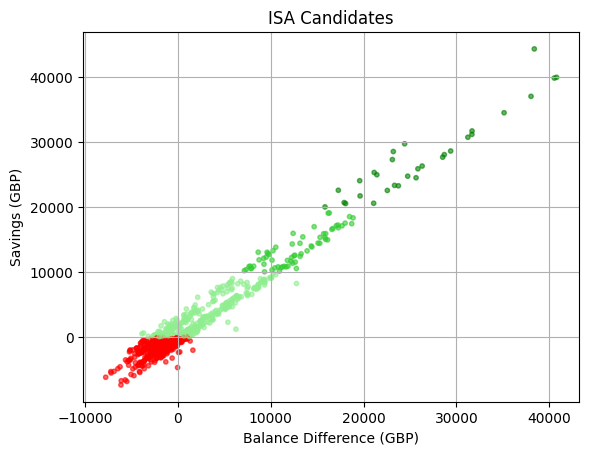

In [133]:
plt.scatter(isa_df['Balance Difference'], isa_df['Savings'], color=colors, marker='o', s=10, alpha=0.6)  # 's' sets the size of the markers
plt.title('ISA Candidates')
plt.xlabel('Balance Difference (GBP)')
plt.ylabel('Savings (GBP)')
plt.grid(True)  # Adds a grid
plt.show()